## Final Project Submission

Please fill out:
* __Student name:__ Cassarra Groesbeck
* __Student pace:__ Part Time/ Flex
* __Scheduled project review date/time:__ 
* __Instructor name:__ Claude Fried
* __Blog post URL:__


# Introduction 
This regression modeling will yield findings to support relevant recommendations for ways renovations may increase the estimated value of a home.


# Objectives
Those findings will include:
- a metric describing overall model performance
- at least two regression model coefficients; that is to say, at least two feature-specific effects on Sale Price.

# Business Understanding
The real estate agency needs to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.



# Data Understanding
This project uses the King County House Sales dataset. For more information, other than what is provided below, see the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

###  Column Names and Descriptions for King County Data Set

<a id='table'></a>


| Column     | Description   |
|------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  `id`         | **Unique identifier for a house**  |
| `date`        | **Date house was sold**  |
| `price`       | **Sale price (prediction target)** |
| `bedrooms`    | **Number of bedrooms**  |
|`bathrooms`    | **Number of bathrooms**   |
|`sqft_living`  | **Square footage of living space in the home**  |
| `sqft_lot`    | **Square footage of the lot**   |
|  `floors`     | **Number of floors (levels) in house**  |
| `waterfront`  | **Whether the house is on a waterfront**  |
| `view`        | **Quality of view from house** |
| `condition`   | **How good the overall condition of the house is. Related to maintenance of house.**  |
| `grade`       | **Overall grade of the house. Related to the construction and design of the house.**  |
| `sqft_above`  | **Square footage of house apart from basement**  |
|`sqft_basement`| **Square footage of the basement**   |
|  `yr_built`   | **Year when house was built**  |
| `yr_renovated`| **Year when house was renovated**  |
| `zipcode`     | **ZIP Code used by the United States Postal Service** |
| `lat`         | **Latitude coordinate**  |
| `long`        | **Longitude coordinate**   |
|`sqft_living15`| **The square footage of interior housing living space for the nearest 15 neighbors**   |
| `sqft_lot15`  | **The square footage of the land lots of the nearest 15 neighbors**   |



# Imports

In [2]:
# The basics
import pandas as pd
import numpy as np

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scipy
import scipy.stats as stats

# rando
from itertools import combinations

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# Bring in the data

In [3]:
# data/kc_house_data.csv
data = pd.read_csv("data/kc_house_data.csv")
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287
21596,1523300157,10/15/2014,325000.0,2,0.75,1020,1076,2.0,NO,NONE,...,7 Average,1020,0.0,2008,0.0,98144,47.5941,-122.299,1020,1357


# Functions

In [4]:
# function to return full statsmodel summary
def model(df, target):
    y = df[target]
    X = df.drop(target, axis=1)

    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

In [5]:
# function to return r_squared values, p table from .summary, and a 
# couple of residual normality checks (hist and qq plot)

def model_it_small(df, target):
    y = df[target]
    X = df.drop(target, axis=1)
    #statsmodel fit
    model = sm.OLS(y, sm.add_constant(X)).fit()  
    
    #kfold
    regression = LinearRegression()
    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
    kfold_r = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
    
    #PLOTS
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle('Normality of Residuals')
    #hist
    sns.histplot(model.resid, ax=ax0)
    ax0.set(xlabel='Residual', ylabel='Frequency', title='Distribution of Residuals')
    #qq
    sm.qqplot(model.resid, fit = True, line = '45', ax=ax1)
    ax1.set(title='QQ Plot')
    plt.show()
    
    #print r_squared values
    print(f'r_sq: {model.rsquared}. r_sq_adjusted: {model.rsquared_adj}. k_fold_r: {kfold_r}')
    
    #return 
    return model.summary().tables[1]



In [6]:
# make colinearity check function
# code from Multicollinearity of Features - Lab, turned it into a function

def collinearity(df):
    #get absolute value of correlations, sort them, and turn into new DF called df
    df=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the columns (Which were only named level_0 and level_1 by default) 
    # into a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    # set index to pairs
    df.set_index(['pairs'], inplace = True)

    # drop level_ columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column as cc rather than 0
    df.columns = ['cc']

    # just correlations over .75, but less than 1.
    df = df[(df.cc>.75) & (df.cc <1)]

    df.drop_duplicates(inplace=True) 

    return df

In [7]:
# colinearity with VIF
# code from Linear Regression - Cumulative Lab, altered to make a df w/sorted values

def get_VIFs_above5(df, target):

    vif_data = sm.add_constant(df.drop(target, axis=1))

    vif = [variance_inflation_factor(vif_data.dropna().values, i)\
           for i in range(vif_data.dropna().shape[1])]

    vif_df = pd.DataFrame(vif, index=vif_data.columns).sort_values(0, ascending=False)
    return vif_df[vif_df[0]>5]

In [8]:
def remove_outliers_from_pdDataFrame(df):
    return df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

def remove_outliers_from_Column(df, column):
    return df[(np.abs(stats.zscore(df[column])) < 3)]


# Exploring the data:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Identify target variable 

In [10]:
target = 'price'

## Extract Catagorical Variables

In [11]:
obj_df = data.select_dtypes(include=object)
obj_df.head()

,date,waterfront,view,condition,grade,sqft_basement
0,10/13/2014,NaN,NONE,Average,7 Average,0.0
1,12/9/2014,NO,NONE,Average,7 Average,400.0
2,2/25/2015,NO,NONE,Average,6 Low Average,0.0
3,12/9/2014,NO,NONE,Very Good,7 Average,910.0
4,2/18/2015,NO,NONE,Average,8 Good,0.0


#### Explore catagorical variables

- [x] 'date' (stays categorical)
- [x] 'waterfront' (will become boolean)
- [x] 'view' (stays categorical)
- [x] 'condtion' (stays categorical)
- [x] 'grade' (ordinal)
- [x] 'sqft_basement' (will become boolean)

### Findings from obj_df exploration:
- 'waterfront'
 - has two values: NO & YES
 - has 2376 nulls, that will need to be addressed before ohe'ing
 - 11% of data is null/ missing
 - 0.7% of properties are waterfront
 - 88.3% of properites are not on waterfront
 - I will change nulls to NO due to less than 1% of properties on waterfront
- 'condition'
 - 5 unique values
 - has zero nulls
- 'view'
 - has 6 values 
 - 89.93% is 'NONE'
 - 63 nulls (0.29%), change to 'NONE' 
- 'grade'
 - 11 unique values
 - has numeric value (3-13) and word description (ex "poor" or "good") associated with each grade assignment
 - need to change to just number grade and delete description
- 'date' 
 - string: 'mm/dd/yyyy'
- 'sqft_basement'
 - float values cast as string
 - 454 missing, shown as '?', 2% missing
 - 12826 '0.0' basement, ie 59% no basement, add new column "has_basement"


__TODO__ for obj_df features to be ohe-ready. I will add to this list as I explore data and will address needed conversions at end before ohe'ing.

1. [x] replace 'waterfront' {np.nan:'NO'} - this will be a boolean feature
2. [x] change 'view' nulls to 'NONE' - will stay catagorical
3. [x] keep 'grade' number and ditch description - this will make the feature ordinal
4. [x] convert 'date' to just numerical month - then seperate by season, change name to 'season_sold'
5. [x] for 'sqft_basement' make new column 'has_basement' with NO or YES
6. [x] if value '0.0' or '?' append new column NO, else YES - this will be a boolean feature
7. [x] make new get_dummies_df of ['view', 'condition', 'has_basement', 'waterfront']
8. [x] pd.get_dummies(dummies_df, drop_first=True)

<a id='values'></a>
### Column Values and Null Counts:

In [12]:
# print .value_counts() for each column in obj_df
for column in obj_df.columns:
    print(f"COLUMN: '{column}'")
    print(f"Number of unique values: {len(obj_df[column].unique())}")
    print(f"Number of nulls: {obj_df[column].isnull().sum()}")
    print(obj_df[column].value_counts())
    print()

COLUMN: 'date'
Number of unique values: 372
Number of nulls: 0
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
8/30/2014      1
5/15/2015      1
1/10/2015      1
5/24/2015      1
7/27/2014      1
Name: date, Length: 372, dtype: int64

COLUMN: 'waterfront'
Number of unique values: 3
Number of nulls: 2376
NO     19075
YES      146
Name: waterfront, dtype: int64

COLUMN: 'view'
Number of unique values: 6
Number of nulls: 63
NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

COLUMN: 'condition'
Number of unique values: 5
Number of nulls: 0
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

COLUMN: 'grade'
Number of unique values: 11
Number of nulls: 0
7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair       

In [13]:
#  null counts
obj_df.isnull().sum()

date                0
waterfront       2376
view               63
condition           0
grade               0
sqft_basement       0
dtype: int64

In [14]:
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           21597 non-null  object
 1   waterfront     19221 non-null  object
 2   view           21534 non-null  object
 3   condition      21597 non-null  object
 4   grade          21597 non-null  object
 5   sqft_basement  21597 non-null  object
dtypes: object(6)
memory usage: 1012.5+ KB


In [15]:
obj_df[['sqft_basement']].head(20)

,sqft_basement
0,0.0
1,400.0
2,0.0
3,910.0
4,0.0
5,1530.0
6,?
7,0.0
8,730.0
9,0.0


In [16]:
type(obj_df['date'][0])

str

#### Tackeling TODO ohe prep list

In [17]:
# 1. replace 'waterfront' {np.nan:'NO'}
data['waterfront'].replace({np.nan:'NO'}, inplace=True)

#check
data['waterfront'].value_counts()

NO     21451
YES      146
Name: waterfront, dtype: int64

In [18]:
# 2. change 'view' nulls to 'NONE'
data['view'].fillna('NONE', inplace=True)

#check
data['view'].value_counts()

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [19]:
# 3. keep 'grade' number (as an int) and ditch description
data['grade'] = [int(grade[:2]) for grade in data['grade']]

#check
data['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [20]:
# 4. convert 'date' to just numerical month
data['date'] = pd.DatetimeIndex(data['date']).month

# catagorize into seasons
seasons = {1:'winter', 2:'winter', 3:'spring',
          4:'spring', 5:'spring', 6:'summer',
          7:'summer', 8:'summer', 9:'fall',
          10:'fall', 11:'fall', 12:'winter'}
    
data['date'] = data['date'].replace(seasons)

# rename date to what it is
data.rename({'date':'season_sold'}, axis=1, inplace=True)

#check
data['season_sold'].value_counts()

spring    6518
summer    6328
fall      5056
winter    3695
Name: season_sold, dtype: int64

In [21]:
# 5. & 6. for 'sqft_basement' make new column "has_basement"
# if value '0.0' or '?' append new column 0, else 1

basement = []
for square_feet in data['sqft_basement']:
    if square_feet == '0.0':
        basement.append('NO')
    elif square_feet == '?':
        basement.append('NO')
    else:
        basement.append('YES')
        
data['has_basement'] = basement

#drop 'TotalBsmtSF'
data = data.drop('sqft_basement', axis=1)

# check 
data.head()

,id,season_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_basement
0,7129300520,fall,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,7,1180,1955,0.0,98178,47.5112,-122.257,1340,5650,NO
1,6414100192,winter,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639,YES
2,5631500400,winter,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6,770,1933,NaN,98028,47.7379,-122.233,2720,8062,NO
3,2487200875,winter,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,YES
4,1954400510,winter,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,NO


In [22]:
# 7. make new dummies_df of ['view', 'condition']
dummies_df = data[['view','condition', 'has_basement', 'waterfront', 'season_sold']]
dummies_df

,view,condition,has_basement,waterfront,season_sold
0,NONE,Average,NO,NO,fall
1,NONE,Average,YES,NO,winter
2,NONE,Average,NO,NO,winter
3,NONE,Very Good,YES,NO,winter
4,NONE,Average,NO,NO,winter
...,...,...,...,...,...
21592,NONE,Average,NO,NO,spring
21593,NONE,Average,NO,NO,winter
21594,NONE,Average,NO,NO,summer
21595,NONE,Average,NO,NO,winter


In [23]:
# 8. pd.get_dummies(dummies_df, drop_first=True)
dummies_df = pd.get_dummies(dummies_df, drop_first=True)
dummies_df.head()

,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,condition_Good,condition_Poor,condition_Very Good,has_basement_YES,waterfront_YES,season_sold_spring,season_sold_summer,season_sold_winter
0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,1,1,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,0,1


### __DUMMIES DROPPED NOTES:__
Take note of the features that have been dropped:
- 'view_AVERAGE' has been dropped
- 'condition_AVERAGE' dropped
- 'has_basement_NO' dropped
- 'waterfront_NO' dropped
- 'season_sold_fall' dropped


## Extract Continuous Variables

In [24]:
# extract out columns with Dtype == int or float for further exploration
cont_df = data.select_dtypes(exclude=object).drop(['id', 'price'], axis=1)
cont_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,7,1180,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,6,770,1933,NaN,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503


In [25]:
# check for nulls 
cont_df.isnull().sum()

bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
grade               0
sqft_above          0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### __NOTES:__ 
3,842 missing values from 'yr_renovated'. Thats too many for imputations or replacement. Nulls may mean N/A. Could turn into boolean: 'renovated_YES' == 1

In [26]:
cont_df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

### __NOTES:__ 
An additional 17,011 values of 0, ie 0 likely means N/A and missing values are just that, missing. That is in fact too many for imputations or replacement. I will need to drop this column.

## Converting zip code to cites

In [27]:
data['zipcode'].value_counts() # ohe these? Find way to reduce. 

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

### Web Scrapping for City Zip Codes

In [28]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [29]:
html_page = requests.get('https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033') # Make a get request to retrieve the page
soup = BeautifulSoup(html_page.content, 'html.parser') # Pass the page contents to beautiful soup for parsing


In [30]:
#soup.prettify

### Extract out just zipcode and city from https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033

In [31]:
#grab an easy to identify thing
span = soup.find('span')

# move up to find sibling of container I want
parent = span.parent

# get to the correct container
box = parent.next_sibling.next_sibling

# get text from container and format how needed
box_text = box.get_text().replace('\n', ',')
box_text = box_text.replace('Zip CodeCityCounty', '')
box_text = box_text.replace('King County,', '')
box_text = box_text.replace(' ... ', '')

# split on the commas and remove last (empty) element
lst = box_text.split(",")
lst.pop()

#check
lst

['98001',
 'Algona',
 '98001',
 'Auburn',
 '98001',
 'Federal Way',
 '98002',
 'Auburn',
 '98003',
 'Auburn',
 '98003',
 'Federal Way',
 '98004',
 'Beaux Arts Village',
 '98004',
 'Bellevue',
 '98004',
 'Clyde Hill',
 '98004',
 'Hunts Point',
 '98004',
 'Yarrow Point',
 '98005',
 'Bellevue',
 '98006',
 'Bellevue',
 '98007',
 'Bellevue',
 '98008',
 'Bellevue',
 '98009',
 'Bellevue',
 '98010',
 'Black Diamond',
 '98011',
 'Bothell',
 '98013',
 'Burton',
 '98013',
 'Vashon',
 '98014',
 'Carnation',
 '98015',
 'Bellevue',
 '98019',
 'Duvall',
 '98022',
 'Enumclaw',
 '98023',
 'Auburn',
 '98023',
 'Federal Way',
 '98024',
 'Fall City',
 '98025',
 'Hobart',
 '98027',
 'Issaquah',
 '98028',
 'Kenmore',
 '98028',
 'Bothell',
 '98029',
 'Issaquah',
 '98030',
 'Kent',
 '98031',
 'Kent',
 '98032',
 'Kent',
 '98033',
 'Kirkland',
 '98034',
 'Kirkland',
 '98035',
 'Kent',
 '98038',
 'Maple Valley',
 '98039',
 'Medina',
 '98040',
 'Mercer Island',
 '98041',
 'Bothell',
 '98042',
 'Covington',
 '9804

In [32]:
# seperate into two lists: codes and cities
codes = []
cities = []
i=0
for element in lst:
    if i %2 == 0:
        codes.append(element)
        i+=1
    else:
        cities.append(element)
        i+=1

### Make a DF with _code_ and _cities_ lists

In [33]:
# use the two lists to make a DF
# empty df
web_df = pd.DataFrame()
web_df['zipcode_web']  = codes
web_df['city_web']  = cities

#check
web_df.head()

,zipcode_web,city_web
0,98001,Algona
1,98001,Auburn
2,98001,Federal Way
3,98002,Auburn
4,98003,Auburn


In [34]:
# use DF to make a dict of 
dictionary = {}
for key in web_df['zipcode_web'].unique():
      dictionary[key] = str(web_df[web_df['zipcode_web'] == key]['city_web'].unique())
        
# check
dictionary

{'98001': "['Algona' 'Auburn' 'Federal Way']",
 '98002': "['Auburn']",
 '98003': "['Auburn' 'Federal Way']",
 '98004': "['Beaux Arts Village' 'Bellevue' 'Clyde Hill' 'Hunts Point' 'Yarrow Point']",
 '98005': "['Bellevue']",
 '98006': "['Bellevue']",
 '98007': "['Bellevue']",
 '98008': "['Bellevue']",
 '98009': "['Bellevue']",
 '98010': "['Black Diamond']",
 '98011': "['Bothell']",
 '98013': "['Burton' 'Vashon']",
 '98014': "['Carnation']",
 '98015': "['Bellevue']",
 '98019': "['Duvall']",
 '98022': "['Enumclaw']",
 '98023': "['Auburn' 'Federal Way']",
 '98024': "['Fall City']",
 '98025': "['Hobart']",
 '98027': "['Issaquah']",
 '98028': "['Kenmore' 'Bothell']",
 '98029': "['Issaquah']",
 '98030': "['Kent']",
 '98031': "['Kent']",
 '98032': "['Kent']",
 '98033': "['Kirkland']",
 '98034': "['Kirkland']",
 '98035': "['Kent']",
 '98038': "['Maple Valley']",
 '98039': "['Medina']",
 '98040': "['Mercer Island']",
 '98041': "['Bothell']",
 '98042': "['Covington' 'Kent']",
 '98045': "['North B

### Make new column on exisiting _data_ df

In [35]:
type(data['zipcode'][0])

numpy.int64

In [36]:
#copy zipcode to new column
data['Location/Area'] = data['zipcode'].astype(str)

In [37]:
# Use dictionary to replace zipcodes with cities
data['Location/Area'] = data['Location/Area'].replace(dictionary)

__Distill Cities down to Areas__

In [38]:
# use new column (now containing city names) to begin a list of areas
new_values = []
for cities in data['Location/Area']:
    if 'Seattle' in cities:
        new_values.append('Seattle Area')
    elif 'Bellevue' in cities:
        new_values.append('Bellevue Area')
    elif 'Auburn' in cities:
        new_values.append('Auburn Area')
    elif 'Kent' in cities:
        new_values.append('Kent Area')
    else:
        new_values.append(cities)

In [39]:
# change column values from cities to Areas (when possible) otherwise remains city name
data['Location/Area'] = new_values

In [40]:
# check
data['Location/Area'].value_counts()

Seattle Area                8973
Auburn Area                 1690
Bellevue Area               1407
Kent Area                   1201
['Kirkland']                 977
['Redmond']                  977
['Newcastle' 'Renton']       874
['Issaquah']                 733
['Renton']                   723
['Maple Valley']             589
['Sammamish' 'Redmond']      441
['Sammamish' 'Issaquah']     359
['Snoqualmie']               308
['Kenmore' 'Bothell']        283
['Mercer Island']            282
['Woodinville']              273
['Enumclaw']                 233
['North Bend']               220
98077                        198
['Bothell']                  195
['Duvall']                   190
['Carnation']                124
['Vashon']                   117
['Black Diamond']            100
['Fall City']                 80
['Medina']                    50
Name: Location/Area, dtype: int64

__NOTES:__
- [x] '98077' needs a City name: Woodinville
- [x] if two cites distilled need to assign an area
 - [x] Bothell area: Kenmore, _Bothell_
 - [x] Bellevue Area: _Kirkland_
 - [x] Sammamish Area: _Sammamish_, _Issaquah_, _Redmond_
 - [x] Newcastle area: Newcastle, _Renton_

In [41]:
# repeat above, further distilling values from 'Location/Area' column
new_values2 = []
for cities in data['Location/Area']:
    if 'Bothell' in cities:
        new_values2.append('Bothell Area')
    elif 'Kirkland' in cities:
        new_values2.append('Bellevue Area')
    elif 'Renton' in cities:
        new_values2.append('Newcastle Area')
    elif 'Sammamish' in cities:
        new_values2.append('Sammamish Area')
    elif 'Issaquah' in cities:
        new_values2.append('Sammamish Area')
    elif 'Redmond' in cities:
        new_values2.append('Sammamish Area')
    elif cities == '98077':
        new_values2.append('Woodinville')
    else:
        new_values2.append(cities.strip("['']"))

# change column values to new list
data['Location/Area'] = new_values2

# check
data['Location/Area'].value_counts()

Seattle Area      8973
Sammamish Area    2510
Bellevue Area     2384
Auburn Area       1690
Newcastle Area    1597
Kent Area         1201
Maple Valley       589
Bothell Area       478
Woodinville        471
Snoqualmie         308
Mercer Island      282
Enumclaw           233
North Bend         220
Duvall             190
Carnation          124
Vashon             117
Black Diamond      100
Fall City           80
Medina              50
Name: Location/Area, dtype: int64

In [42]:
# looks good enough for get_dummies then add to dummies_df

### Get Dummies for new column _data['Location/Area']_

In [43]:
zipcode_dummies = pd.get_dummies(data[['Location/Area']], drop_first=True)

# check and take note of what has been dropped
zipcode_dummies

,Location/Area_Bellevue Area,Location/Area_Black Diamond,Location/Area_Bothell Area,Location/Area_Carnation,Location/Area_Duvall,Location/Area_Enumclaw,Location/Area_Fall City,Location/Area_Kent Area,Location/Area_Maple Valley,Location/Area_Medina,Location/Area_Mercer Island,Location/Area_Newcastle Area,Location/Area_North Bend,Location/Area_Sammamish Area,Location/Area_Seattle Area,Location/Area_Snoqualmie,Location/Area_Vashon,Location/Area_Woodinville
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21593,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21595,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [44]:
# ahhhh, cant really tell what was dropped: need some code to help
for area in [f'Location/Area_{name}' for name in data['Location/Area'].unique()]:
    if area not in zipcode_dummies.columns:
        print(area)

Location/Area_Auburn Area


In [45]:
# concatinate with existing dummies_df
dummies_df = pd.concat([dummies_df, zipcode_dummies], axis=1)

# check
dummies_df

,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,condition_Good,condition_Poor,condition_Very Good,has_basement_YES,waterfront_YES,...,Location/Area_Maple Valley,Location/Area_Medina,Location/Area_Mercer Island,Location/Area_Newcastle Area,Location/Area_North Bend,Location/Area_Sammamish Area,Location/Area_Seattle Area,Location/Area_Snoqualmie,Location/Area_Vashon,Location/Area_Woodinville
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21593,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21594,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21595,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Add the above to 
### __DUMMIES DROPPED NOTES:__
Take note of the features that have been dropped:
- 'view_AVERAGE' has been dropped
- 'condition_AVERAGE' dropped
- 'has_basement_NO' dropped
- 'waterfront_NO' dropped
- 'Location/Area_Auburn Area'



## Paring Down Data:
__Get two df's in order__ 

In [46]:
# clean up cont_df (continuous features)

# re define cont_df with relevant columns
relevant_columns = ['price',
                   'bedrooms',
                   'bathrooms',
                   'sqft_living',
                   'sqft_lot',
                   'floors',
                   'grade',
                   'sqft_above',
                   'yr_built',
                   'sqft_living15',
                   'sqft_lot15']
cont_df = data[relevant_columns]

#check
cont_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,7,1180,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,7,2170,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,6,770,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,7,1050,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,8,1680,1987,1800,7503


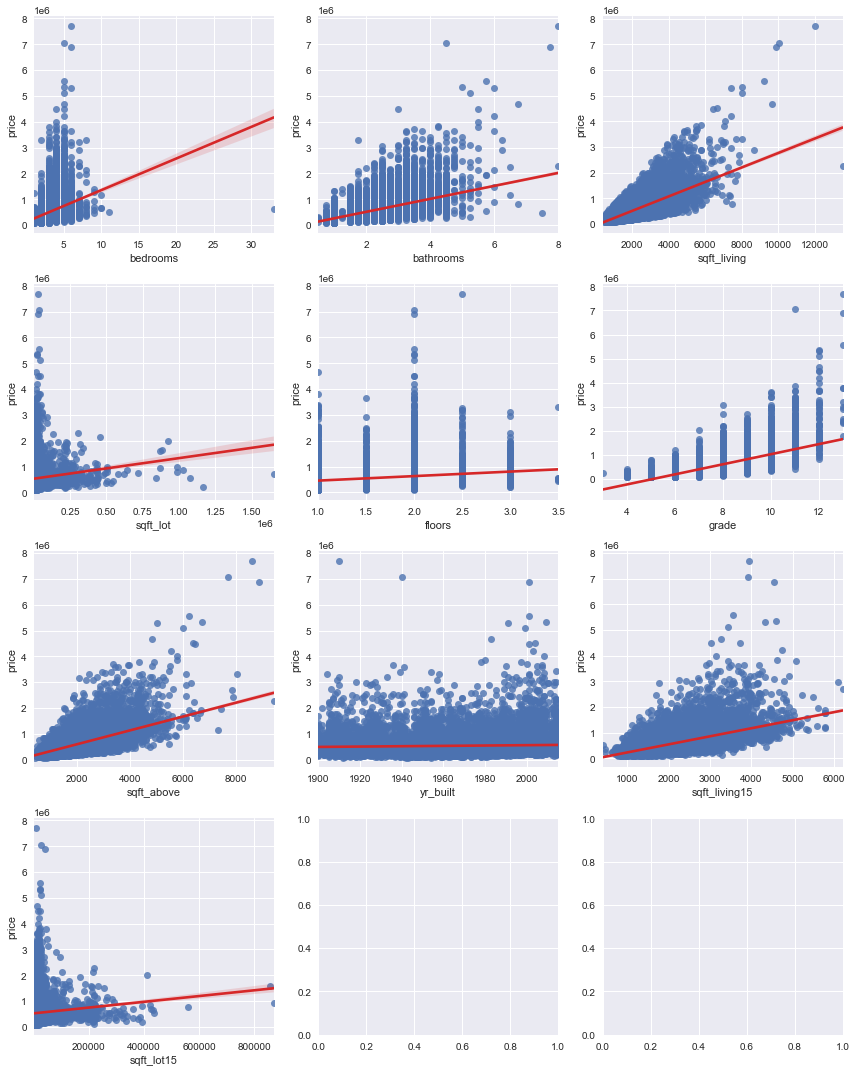

In [47]:
# check continuous features, some maybe catagorical features left in, they are ordinal

#looping over all columns  
plots = cont_df.drop('price', axis=1)

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 15))
fig.set_tight_layout(True)

for index, col in enumerate(plots.columns):
    ax = axes[index//3][index%3]
    sns.regplot(x = col, y = 'price', data = cont_df, ax=ax, line_kws={"color": "tab:red"})
    ax.set_xlabel(col)
    ax.set_ylabel("price")

 ### __NOTES:__
- 'year_built' is a flat line and has no relationship with 'price'
- 'floors' is on the cusp, I will keep for now
- 'bedrooms', 'sqft_lot15', 'sqft_lot', and 'sqft_living' have obvious outliers


In [48]:
# drop 
cont_df = cont_df.drop('yr_built', axis=1)

#check
cont_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,7,1180,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,7,2170,1690,7639
2,180000.0,2,1.00,770,10000,1.0,6,770,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,7,1050,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,8,1680,1800,7503


In [49]:
# is there really a 30+ bedroom house?
cont_df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [50]:
# drop that 1 it's obviously an anomaly 
cont_df = cont_df[cont_df['bedrooms']<30]

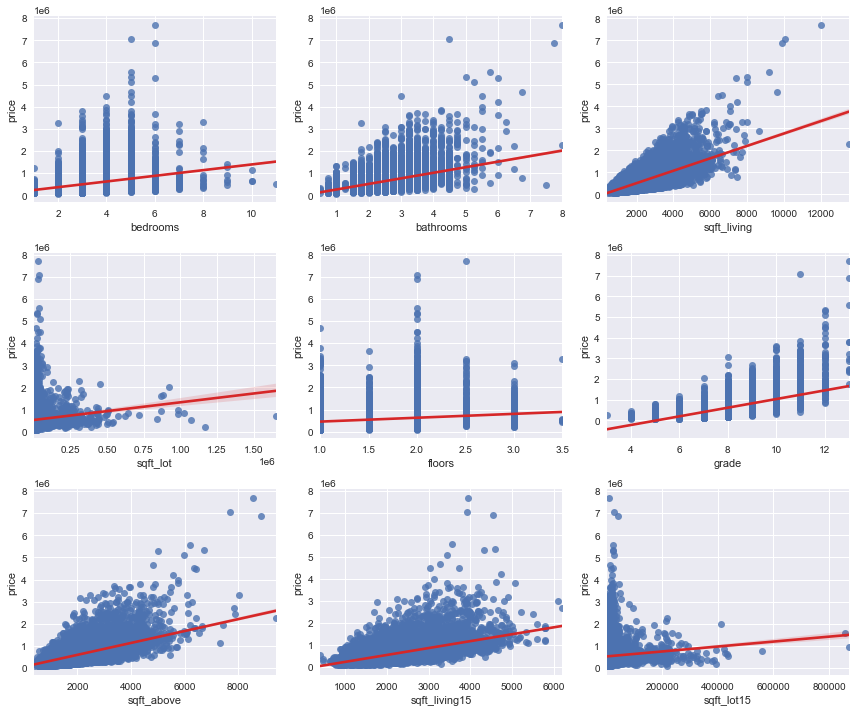

In [51]:
# again now that feature have been dropped, and 33 room house removed
plots = cont_df.drop('price', axis=1)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 10))
fig.set_tight_layout(True)

for index, col in enumerate(plots.columns):
    ax = axes[index//3][index%3]
    sns.regplot(x = col, y = 'price', data = cont_df, ax=ax, line_kws={"color": "tab:red"})
    ax.set_xlabel(col)
    ax.set_ylabel("price")

# Build Baseline Model

### Build baseline model with highest correlated feature

In [52]:
cont_df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.701929
grade            0.667964
sqft_above       0.605392
sqft_living15    0.585267
bathrooms        0.525915
bedrooms         0.315961
floors           0.256820
sqft_lot         0.089879
sqft_lot15       0.082849
Name: price, dtype: float64

In [53]:
# use 'sqft_living' as baseline model feature
# baseline model
baseline_model_df = cont_df[['sqft_living', 'price']]

baseline = model(baseline_model_df, target)
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 28 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:49:30   Log-Likelihood:            -3.0005e+05
No. Observations:               21596   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.401e+04   4410.123     -9.980      0.000   -5.27e+04   -3.54e+04
sqft_living   280.8688      1.939    144.820      0.000     277.067     284.670
==============================================================================
Omnibus:                    14801.492   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542642.481
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

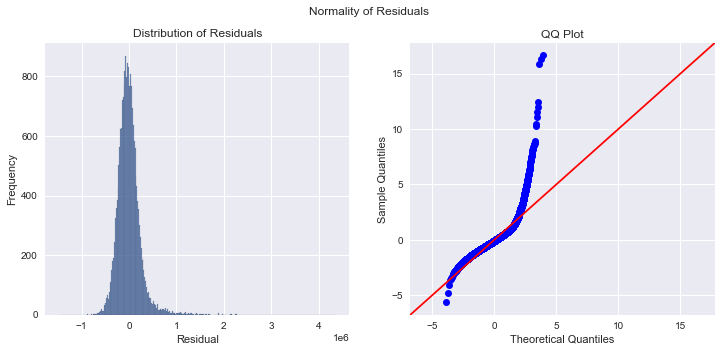

In [54]:
# a look at the residuals
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(baseline.resid, ax=ax0)
ax0.set(xlabel='Residual', ylabel='Frequency', title='Distribution of Residuals')

sm.qqplot(baseline.resid, fit = True, line = '45', ax=ax1)
ax1.set(title='QQ Plot')

fig.suptitle('Normality of Residuals')

plt.show()

### __NOTES:__
Log transform target and try again

# Log transform _'price'_

In [55]:
cont_df['price']

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21592    360000.0
21593    400000.0
21594    402101.0
21595    400000.0
21596    325000.0
Name: price, Length: 21596, dtype: float64

In [56]:
# log price and store in new column 'price_log'
cont_df['price_log'] = np.log(cont_df['price'])

In [57]:
# drop 'price' from cont_df
cont_df = cont_df.drop('price', axis=1)

# define new df
base2_model_log = cont_df[['sqft_living', 'price_log']].dropna()

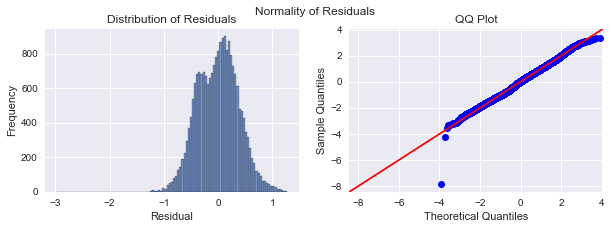

r_sq: 0.48331566140862225. r_sq_adjusted: 0.48329173419094185. k_fold_r: 0.4830740326863596


,coef,std err,t,P>|t|,[0.025,0.975]
const,12.2187,0.006,1915.377,0.000,12.206,12.231
sqft_living,0.0004,2.81e-06,142.125,0.000,0.000,0.000


In [58]:
# redefine target
target = 'price_log'

# model it 
model_it_small(base2_model_log, target)

# Bring in the other features and model with the other features

## Model 'model_log'

In [59]:
# concat cont_df to dummies_df
model_log = pd.concat([cont_df, dummies_df], axis=1).dropna(axis=0)

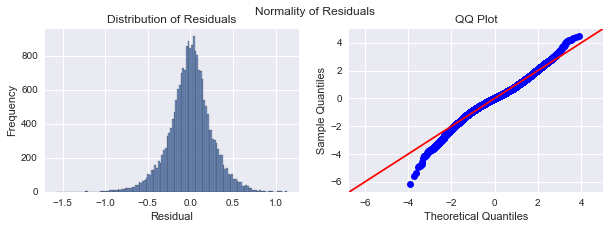

r_sq: 0.7671800703242926. r_sq_adjusted: 0.7667480222061285. k_fold_r: 0.7658897149166523


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.9629,0.021,533.082,0.000,10.923,11.003
bedrooms,-0.0074,0.003,-2.967,0.003,-0.012,-0.003
bathrooms,0.0205,0.004,5.189,0.000,0.013,0.028
sqft_living,9.148e-05,7.61e-06,12.028,0.000,7.66e-05,0.000
sqft_lot,5.739e-07,6.08e-08,9.441,0.000,4.55e-07,6.93e-07
floors,0.0508,0.005,11.190,0.000,0.042,0.060
grade,0.1295,0.003,47.791,0.000,0.124,0.135
sqft_above,8.283e-05,8.33e-06,9.940,0.000,6.65e-05,9.92e-05
sqft_living15,9.763e-05,4.46e-06,21.886,0.000,8.89e-05,0.000
sqft_lot15,-2.232e-07,9.5e-08,-2.349,0.019,-4.09e-07,-3.7e-08


In [60]:
model_it_small(model_log, target)

### __NOTES:__
Features with p_values above .05 and CI that spans 0:
- season_sold_winter
- season_sold_summer
- view_FAIR

# Remodel with above features removed 

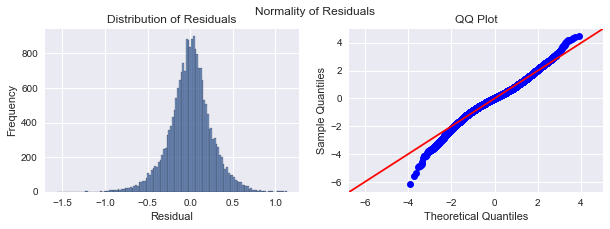

r_sq: 0.7671591450839448. r_sq_adjusted: 0.7667595202749693. k_fold_r: 0.7660850960481645


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.9699,0.020,551.884,0.000,10.931,11.009
bedrooms,-0.0074,0.003,-2.963,0.003,-0.012,-0.003
bathrooms,0.0205,0.004,5.188,0.000,0.013,0.028
sqft_living,9.146e-05,7.61e-06,12.024,0.000,7.65e-05,0.000
sqft_lot,5.737e-07,6.08e-08,9.440,0.000,4.55e-07,6.93e-07
floors,0.0508,0.005,11.174,0.000,0.042,0.060
grade,0.1295,0.003,47.786,0.000,0.124,0.135
sqft_above,8.287e-05,8.33e-06,9.945,0.000,6.65e-05,9.92e-05
sqft_living15,9.767e-05,4.46e-06,21.898,0.000,8.89e-05,0.000
sqft_lot15,-2.245e-07,9.5e-08,-2.363,0.018,-4.11e-07,-3.83e-08


In [61]:
Ps_dropped1 = model_log.drop(['season_sold_winter', 
                              'season_sold_summer', 
                              'view_FAIR'], axis=1)
model_it_small(Ps_dropped1, target)

### __NOTES:__
All p_values below .05. I will move on to check for multicollinearity 

## Multicollinearity of Features 

In [62]:
collinearity(Ps_dropped1)

,cc
pairs,
"(sqft_above, sqft_living)",0.876448
"(sqft_living, grade)",0.762776
"(sqft_living, sqft_living15)",0.756400
"(grade, sqft_above)",0.756069
"(sqft_living, bathrooms)",0.755755


In [63]:
get_VIFs_above5(Ps_dropped1, target)

,0
const,131.940193
sqft_living,16.283334
sqft_above,15.887584


# Remodel  dropping 'sqft_above' 

In [64]:
drop_collin_feature = Ps_dropped1.drop('sqft_above', axis=1).dropna(axis=0)

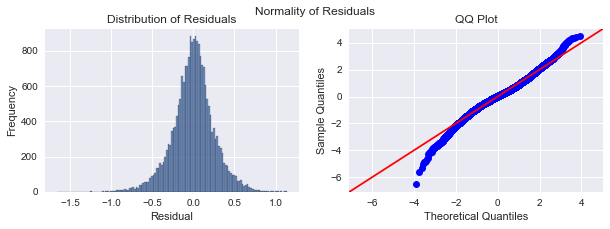

r_sq: 0.7660908693555001. r_sq_adjusted: 0.7657002794068382. k_fold_r: 0.765019749455091


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.9498,0.020,552.488,0.000,10.911,10.989
bedrooms,-0.0078,0.003,-3.099,0.002,-0.013,-0.003
bathrooms,0.0196,0.004,4.938,0.000,0.012,0.027
sqft_living,0.0002,4.28e-06,36.004,0.000,0.000,0.000
sqft_lot,5.913e-07,6.09e-08,9.713,0.000,4.72e-07,7.11e-07
floors,0.0631,0.004,14.410,0.000,0.055,0.072
grade,0.1333,0.003,49.630,0.000,0.128,0.139
sqft_living15,0.0001,4.44e-06,23.092,0.000,9.39e-05,0.000
sqft_lot15,-2.236e-07,9.52e-08,-2.349,0.019,-4.1e-07,-3.7e-08
view_EXCELLENT,0.1219,0.019,6.454,0.000,0.085,0.159


In [65]:
model_it_small(drop_collin_feature, target)

### __NOTES:__
P values look good, I will re check collinearity not that 'sqft_above' has been deleted

In [66]:
collinearity(drop_collin_feature)

,cc
pairs,
"(grade, sqft_living)",0.762776
"(sqft_living15, sqft_living)",0.756400
"(bathrooms, sqft_living)",0.755755


In [67]:
get_VIFs_above5(drop_collin_feature, target)

,0
const,130.577029
sqft_living,5.130438


### __NOTES:__
'sqft_living' slighlty above 5. I do not want to delete this feature. The above cell shows 'sqft_living15' correlating with 'sqft_living'. This feature is not specific to the home and has to do with the 15 houses nearest. I will delete this feture and re check VIF's. 

In [68]:
final_drop = drop_collin_feature.drop('sqft_living15', axis=1)

In [69]:
get_VIFs_above5(final_drop, target)

,0
const,130.002476


### __NOTES:__
Great! there are no features with VIF greater than 5

# Model with 'sqft_living15' dropped

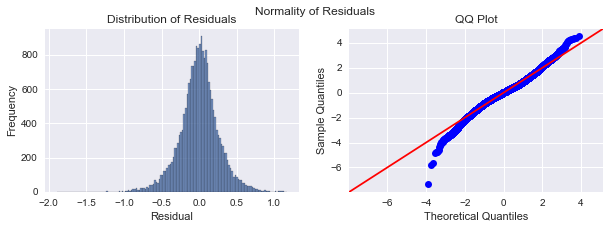

r_sq: 0.7603054463462052. r_sq_adjusted: 0.7599163318110529. k_fold_r: 0.7591729019217106


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.9801,0.020,548.513,0.000,10.941,11.019
bedrooms,-0.0084,0.003,-3.311,0.001,-0.013,-0.003
bathrooms,0.0144,0.004,3.603,0.000,0.007,0.022
sqft_living,0.0002,4e-06,48.048,0.000,0.000,0.000
sqft_lot,5.198e-07,6.15e-08,8.445,0.000,3.99e-07,6.4e-07
floors,0.0568,0.004,12.845,0.000,0.048,0.066
grade,0.1514,0.003,58.161,0.000,0.146,0.156
sqft_lot15,-8.014e-08,9.62e-08,-0.833,0.405,-2.69e-07,1.08e-07
view_EXCELLENT,0.1316,0.019,6.885,0.000,0.094,0.169
view_GOOD,0.0397,0.014,2.921,0.003,0.013,0.066


In [70]:
model_it_small(final_drop, target)

### __NOTES:__
'sqft_lot15' p_value grow to 0.405

# Remodel with _'sqft_lot15'_ dropped

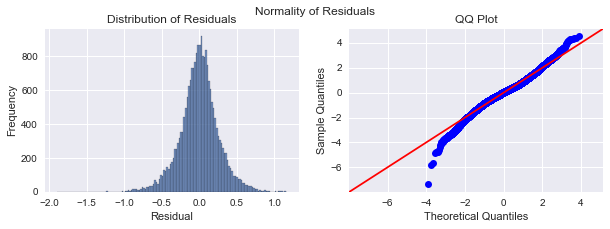

r_sq: 0.7602977264907411. r_sq_adjusted: 0.7599197348716458. k_fold_r: 0.759313214517095


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.9794,0.020,548.982,0.000,10.940,11.019
bedrooms,-0.0083,0.003,-3.281,0.001,-0.013,-0.003
bathrooms,0.0145,0.004,3.623,0.000,0.007,0.022
sqft_living,0.0002,3.98e-06,48.154,0.000,0.000,0.000
sqft_lot,4.861e-07,4.64e-08,10.476,0.000,3.95e-07,5.77e-07
floors,0.0570,0.004,12.891,0.000,0.048,0.066
grade,0.1514,0.003,58.162,0.000,0.146,0.156
view_EXCELLENT,0.1315,0.019,6.880,0.000,0.094,0.169
view_GOOD,0.0397,0.014,2.922,0.003,0.013,0.066
view_NONE,-0.1151,0.008,-14.922,0.000,-0.130,-0.100


In [71]:
# oh the irony of the name
# drop 'sqft_lot15' from final_drop
final_drop_again = final_drop.drop('sqft_lot15', axis=1)

# model it 
model_it_small(final_drop_again, target)

### __NOTES:__
Great, the p_values are in a good place again. Try adding interactions to boost r_squared

# Interactions

In [72]:
X = final_drop_again.drop(target, axis=1)
y = final_drop_again[target]

regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)

features = list(X.columns)
combos = combinations(features, 2)
r_2s_dict = {pair:None for pair in combos}

# use pairs list and find r_2's
for k,v in r_2s_dict.items():
    
    # make copy of df so you don't mess anything up
    X_interact = X.copy()
    
    # use pairs
    # new column in X_interact with product of predictors
    X_interact[f'{k}'] = X[f'{k[0]}'] * X[f'{k[1]}']
    # r2 with combo feature added
    r_2_with_interaction = np.mean(cross_val_score(regression, X_interact, y, scoring='r2', cv=crossvalidation))
    # store r_2 and pair in a dictionary
    r_2s_dict[k] = r_2_with_interaction
    

# sort by r_2 value and extract top 3 pairs (the last 3)
top_3 = dict(sorted(r_2s_dict.items(), key=lambda item: item[1])[-3:])

top_3

{('sqft_living', 'Location/Area_Seattle Area'): 0.7633098356738036,
 ('sqft_lot', 'Location/Area_Seattle Area'): 0.7645681772758762,
 ('grade', 'Location/Area_Seattle Area'): 0.76623291613592}

### Get r_squared with interactions added

In [73]:
# redefine X so this cell can run multiple times
X = final_drop_again.drop(target, axis=1)

# add interactions columns to df 

# TOP 3
X["'grade'*'Location/Area_Seattle Area'"] = X['grade'] * X['Location/Area_Seattle Area']
#X["'sqft_lot'*'Location/Area_Seattle Area'"] = X['sqft_lot'] * X['Location/Area_Seattle Area']


# Then use 10-fold cross-validation ...
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))


0.766086357665493

#  FINAL MODEL with interactions added

In [74]:
# add target into X df
X[target] = final_drop_again[target]

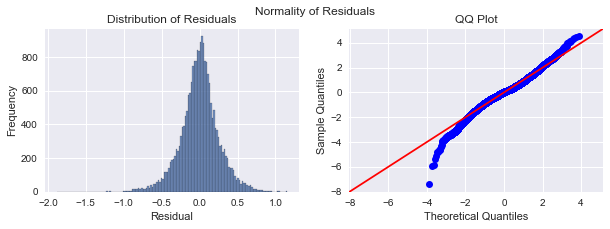

r_sq: 0.7671784853507806. r_sq_adjusted: 0.7668005283464799. k_fold_r: 0.76623291613592


,coef,std err,t,P>|t|,[0.025,0.975]
const,11.2402,0.022,505.080,0.000,11.197,11.284
bedrooms,-0.0133,0.003,-5.299,0.000,-0.018,-0.008
bathrooms,0.0088,0.004,2.216,0.027,0.001,0.017
sqft_living,0.0002,3.99e-06,52.673,0.000,0.000,0.000
sqft_lot,5.381e-07,4.58e-08,11.756,0.000,4.48e-07,6.28e-07
floors,0.0414,0.004,9.407,0.000,0.033,0.050
grade,0.1177,0.003,40.688,0.000,0.112,0.123
view_EXCELLENT,0.1100,0.019,5.834,0.000,0.073,0.147
view_GOOD,0.0300,0.013,2.239,0.025,0.004,0.056
view_NONE,-0.1015,0.008,-13.318,0.000,-0.116,-0.087


In [75]:
model_it_small(X, target)

### __NOTES:__
P_values still below 0.05 I am stopping here 

### Investigating Linearity

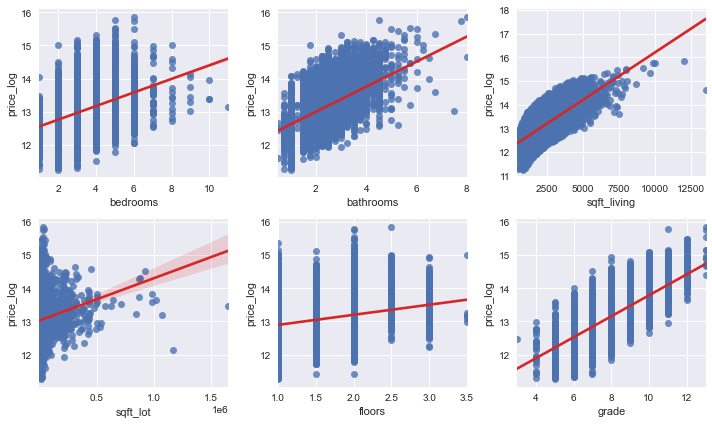

In [76]:
# Linearity?
x = X[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','grade', 'price_log']]
plots = x.drop(target, axis=1)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 6))
fig.set_tight_layout(True)

for index, col in enumerate(plots.columns):
    ax = axes[index//3][index%3]
    sns.regplot(x = col, y = target, data = x, ax=ax, line_kws={"color": "tab:red"})
    ax.set_xlabel(col)
    ax.set_ylabel("price_log")

### Investigating Homoscedasticity

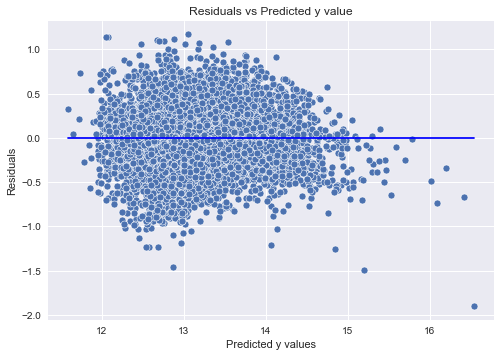

In [77]:
# plot the residuals against predicted values to 
y = final_drop_again[target]
X2 = final_drop_again.drop(target, axis=1)

#statsmodel fit

#final_model = sm.OLS(y, sm.add_constant(X2)).fit()
y_pred = final_model.fittedvalues

# check for homoscedasticity
p = sns.scatterplot(x=y_pred,y=final_model.resid)
plt.xlabel('Predicted y values')
plt.ylabel('Residuals')
#plt.xlim(70,100)
p = sns.lineplot(x=[y_pred.min(),y_pred.max()],y=[0,0],color='blue')
p = plt.title('Residuals vs Predicted y value')

### Investigating Multicollinearity (Independence Assumption)

In [78]:
collinearity(final_drop_again)

,cc
pairs,
"(grade, sqft_living)",0.762776
"(sqft_living, bathrooms)",0.755755


In [79]:
get_VIFs_above5(final_drop_again, target)

,0
const,129.765679


### __NOTES:__
Perfect, there are no values above 5!

# Interpretations
The r squared value of .760 tells us this final linear regression model is able to explain 76% of the variability observed in Sale Price. With an identical adjusted r squared we can be confident in the precision and reliability of this model. 
Since the prob(f-statistic) is zero, we can also be confident there is evidence that suggests there *__is__* a linear relationship between Sale Price and this set of predictor variables. Final recommendations, based on this models coeffiecient values, are listed below, in section [__Final Recommendations__](#final_recos)

In [80]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     2011.
Date:                Tue, 28 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:51:02   Log-Likelihood:                -1368.1
No. Observations:               21596   AIC:                             2806.
Df Residuals:                   21561   BIC:                             3086.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           10.9794      0.020    548.982      0.000      10.940      11.019
bedrooms                        -0.0083      0.003     -3.281      0.001      -0.013      -0.003
bathrooms                        0.0145      0.004      3.623      0.000       0.007       0.022
sqft_living                      0.0002   3.98e-06     48.154      0.000       0.000       0.000
sqft_lot                      4.861e-07   4.64e-08     10.476      0.000    3.95e-07    5.77e-07
floors                           0.0570      0.004     12.891      0.000       0.048       0.066
grade                            0.1514      0.003     58.162      0.000       0.146       0.156
view_EXCELLENT                   0.1315      0.019      6.880      0.000       0.094       0.169
view_GOOD                        0.0397      0.014      2.922      0.003       0.013       0.066
view_NONE                       -0.1151      0.008    -14.922      0.000      -0.130      -0.100
condition_Fair                  -0.1403      0.020     -6.989      0.000      -0.180      -0.101
condition_Good                   0.0834      0.004     19.241      0.000       0.075       0.092
condition_Poor                  -0.1483      0.048     -3.081      0.002      -0.243      -0.054
condition_Very Good              0.1803      0.007     26.318      0.000       0.167       0.194
has_basement_YES                 0.0355      0.004      8.218      0.000       0.027       0.044
waterfront_YES                   0.3303      0.026     12.512      0.000       0.279       0.382
season_sold_spring               0.0466      0.004     12.159      0.000       0.039       0.054
Location/Area_Bellevue Area      0.6932      0.008     83.146      0.000       0.677       0.710
Location/Area_Black Diamond      0.2726      0.027     10.231      0.000       0.220       0.325
Location/Area_Bothell Area       0.4356      0.013     32.518      0.000       0.409       0.462
Location/Area_Carnation          0.3326      0.024     13.661      0.000       0.285       0.380
Location/Area_Duvall             0.3465      0.020     17.458      0.000       0.308       0.385
Location/Area_Enumclaw           0.0749      0.018      4.081      0.000       0.039       0.111
Location/Area_Fall City          0.4629      0.030     15.530      0.000       0.404       0.521
Location/Area_Kent Area          0.0568      0.010      5.822      0.000       0.038       0.076
Location/Area_Maple Valley       0.1812      0.012     14.550      0.000       0.157       0.206
Location/Area_Medina             1.2126      0.037     32.517      0.000       1.139       1.286
Location/Area_Mercer Island      0.8252      0.017     48.783      0.000       0.792       0.858
Location/Area_Newcastle Area     0.2514      0.009     27.856      0.000    

In [81]:
round(final_model.params, 3)*100

const                           1097.9
bedrooms                          -0.8
bathrooms                          1.5
sqft_living                        0.0
sqft_lot                           0.0
floors                             5.7
grade                             15.1
view_EXCELLENT                    13.2
view_GOOD                          4.0
view_NONE                        -11.5
condition_Fair                   -14.0
condition_Good                     8.3
condition_Poor                   -14.8
condition_Very Good               18.0
has_basement_YES                   3.6
waterfront_YES                    33.0
season_sold_spring                 4.7
Location/Area_Bellevue Area       69.3
Location/Area_Black Diamond       27.3
Location/Area_Bothell Area        43.6
Location/Area_Carnation           33.3
Location/Area_Duvall              34.7
Location/Area_Enumclaw             7.5
Location/Area_Fall City           46.3
Location/Area_Kent Area            5.7
Location/Area_Maple Valle

<a id='final_recos'></a>

# Final Recommendations:
__Renovations should be focused on upgrading Condition and Grade of the home. Additionally, adding a floor will increase value.__ 

The top ways renovations can increase home value: 
-	__Upgrading home _Condition_ from AVERAGE to GOOD will increase home value by 8.3%__
-	__Improvement in _Condition_ from AVERAGE to VERY GOOD will increase value by 18.0%__
-	__For every increase in _Grade_ level, the home value will increase by 15.1%__
- __For every additional _floor_, home value increases by 5.7%__
 

Below I have placed reminders of the description of _GRADE_ and _CONDITION_ from [table](#table) at top of this notebook. As well as additional information from the King County [Residential Glossary of Terms](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#top), and the [values](#values) from the data.


__GRADE__: _Overall grade of the house. Related to the construction and design of the house. Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value. (See Glossary in Area Report for Residential Building Grades in use by the King County Department of Assessments.)_  

Classifications:
- 3 – Poor
- 4 – Low
- 5 – Fair
- 6 – Low Average
- 7 – Average
- 8 – Good 
- 9 - Better         
- 10 - Very Good    
- 11 - Excellent     
- 12 - Luxury          
- 13 - Mansion        

__CONDITION__: _How good the overall condition of the house is. Related to maintenance of house._ 

Classifications:
- Average     
- Good         
- Very Good     
- Fair           
- Poor            



# Next Steps
- Remove outliers from features, one by one, modeling between each, and try to eliminate the outlying residuals.
- Maybe split modeling data into urban and rural locations. 

# Linear Regression Modeling of the King County House Sales dataset



## Overview

The regression modeling will yield findings to support relevant recommendations for ways renovations may increase the estimated value of a home. Those findings include:
 - an R squared metric to describe the overall model performance.
 - multicollinearity checks with VIF (Variance Inflation Factor) values 
 - visual modeling to show:
  - distribution of the model residuals 
  - linearity checks to show the relationship between Sale Price and features used
  - a homoscedasticity check of the final model. 
  
Finally, there are three feature-specific effects on Sale Price stated in the __Final Recommendations__ sections 


## Business Problem

A real estate agency needs to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.

## The Data

This regression analysis uses the King County House Sales dataset. For more information, other than what is provided below, see the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

<img src='README_images/column_description_tabel.png'>


## Methods

Below is a summary of how I arrived at the final model:
- Baseline Model with highest correlated feature: ‘sqft_living’
<img src='README_images/baseline_model.png'>
- plot histogram of baseline model residual and a QQ-plot (moving forward, these two plots are a part of function used to model, see below)
<img src='README_images/Baseline_dist_QQ.png'>
- Log transform target: ‘price’. (All models going forward used ‘price_log’ as target variable)
- Model with ‘price_log’ and ‘sqft_living’
<img src='README_images/price_log_initial.png'>
- Model with other features added 
- Remove features with p-values greater than .05: 
 - ‘season_sold_winter’
 - ‘season_sold_summer’
 - ‘view_fair’
- Model with 3 said features removed. P-values stayed under .05
- Check for collinearity, removed 1 feature based on high VIF: ‘sqft_above’
- Model with VIF feature removed, ‘sqft_above’. P-values stayed under .05.
- multicollinearity check again. Drop one more feature: ‘sqft_living15’
- Model with additional feature dropped: ‘sqft_living15’
- This made high p value of ‘sqft_lot15’. Dropped that feature
- Model. P-values all under .05. 
- Add interactions to boost r squared 
- __FINAL MODEL__, All p-s stayed under .05. Stopped here.
<img src='README_images/final_model1.png'><img src='README_images/final_model2.png'><img src='README_images/final_model3.png'>
<img src='README_images/final_normality.png'>

From here I checked the reamaining 3 assumptions of Linear Regression (Normality checked with each model, histogram of residuals and QQ-plot) 
- Linearity: scatter plots of continuous features used in final model
<img src='README_images/final_linearity.png'>
- Homoscedasticity: scatter plot of final model residuals
<img src='README_images/final_homo.png'>
- Independence: re check to ensure no features have VIF greater than 5


## Conclusions

The r squared value of .760 tells us this final linear regression model is able to explain 76% of the variability observed in Sale Price. With an identical adjusted r squared we can be confident in the precision and reliability of this model. 
Additionally, since the prob(f-statistic) is zero, we can also be confident there is evidence that suggests there *__is__* a linear relationship between Sale Price and this set of predictor variables. 

## Recommendations

Renovations should focus on upgrading _Condition_ and _Grade_ of the home. In addition, adding a _floor_ will increase value. 

The top ways renovations can increase home value: 
- __Upgrading home _Condition_ from AVERAGE to GOOD will increase home value by 8.3%__
- __Improvement in _Condition_ from AVERAGE to VERY GOOD will increase value by 18.0%__
- __For every increase in _Grade_ level, the home value will increase by 15.1%__
- __For every additional _Floor_, home value increases by 5.7%__

Below I have placed reminders of the description of _GRADE_ and _CONDITION_ from [table](#table) at top of this notebook. As well as additional information from the King County [Residential Glossary of Terms](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#top).


__GRADE__: _Overall grade of the house. Related to the construction and design of the house. Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value. (See Glossary in Area Report for Residential Building Grades in use by the King County Department of Assessments.)_  
       
__CONDITION__: _How good the overall condition of the house is. Related to maintenance of house._ 


 
## Next Steps

- Remove outliers from features, one by one, modeling between each, and try to eliminate the outlying residuals shown in bottom right corner of above image.
- Split modeling data into urban and rural locations.


